# Analysis Notebook

**SC/MATH 1130 A - Fall 2025**  
**Project:** The Impact of AI on Canadian Wages

---

## Research Questions

We're exploring three main questions about AI's impact on Canadian wages:

**1. Historical Wage Growth (2006-2024)**  
Have wages grown differently in AI-adopting industries compared to low-AI sectors? Is AI creating wage inequality?

**2. Entry-Level Job Market**  
Has AI adoption reduced entry-level opportunities or compressed starting wages in high-exposure occupations?

**3. Occupational Vulnerability**  
Which jobs and regions face the highest risk from AI displacement? Which are safest?

---

---

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

# Setup paths
BASE_DIR = Path("..")
MERGED_DATA = BASE_DIR / "data" / "merged"
OUTPUTS_FIGURES = BASE_DIR / "outputs" / "figures"
OUTPUTS_TABLES = BASE_DIR / "outputs" / "tables"

# Create output directories
OUTPUTS_FIGURES.mkdir(parents=True, exist_ok=True)
OUTPUTS_TABLES.mkdir(parents=True, exist_ok=True)

# Set plotting style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

print("✅ Setup complete!")
print(f"Output figures: {OUTPUTS_FIGURES}")
print(f"Output tables: {OUTPUTS_TABLES}")

✅ Setup complete!
Output figures: ../outputs/figures
Output tables: ../outputs/tables


---

## Load Data

We're loading the master dataset created in `01_data_cleaning.ipynb`.

In [2]:
# Load merged dataset from cleaning notebook
df = pd.read_csv(MERGED_DATA / "master_dataset.csv")

print(f"Dataset shape: {df.shape}")
print(f"Years: {df['Reference_Period'].min()} - {df['Reference_Period'].max()}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset shape: (613008, 17)
Years: 2006.0 - 2024.0

Columns: ['NOC_CNP', 'NOC_Title_Standardized', 'Province', 'Region', 'Reference_Period', 'Annual_Wage_Flag_Salaire_annuel', 'Low_Wage_Hourly', 'Median_Wage_Hourly', 'High_Wage_Hourly', 'Average_Wage_Hourly', 'Quartile1_Wage_Hourly', 'Quartile3_Wage_Hourly', 'missing_wage_flag', 'is_entry_level', 'Industry', 'AI_Exposure_Score', 'AI_Exposure_Category']


,NOC_CNP,NOC_Title_Standardized,Province,Region,Reference_Period,Annual_Wage_Flag_Salaire_annuel,Low_Wage_Hourly,Median_Wage_Hourly,High_Wage_Hourly,Average_Wage_Hourly,Quartile1_Wage_Hourly,Quartile3_Wage_Hourly,missing_wage_flag,is_entry_level,Industry,AI_Exposure_Score,AI_Exposure_Category
0,NaN,NaN,NaN,NaN,NaN,0.0,8.17,28.00,49.45,NaN,NaN,NaN,0,0,Other,0.0,NaN
1,NaN,NaN,NaN,NaN,NaN,0.0,17.95,40.06,64.97,NaN,NaN,NaN,0,0,Other,0.0,NaN
2,NaN,NaN,NaN,NaN,NaN,0.0,19.23,45.67,66.67,NaN,NaN,NaN,0,0,Other,0.0,NaN
3,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,Other,0.0,NaN
4,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,Other,0.0,NaN


In [3]:
# Quick data quality check
print("Missing values per column:")
print(df.isnull().sum())

print("\nData types:")
print(df.dtypes)

Missing values per column:
NOC_CNP                            527008
NOC_Title_Standardized             524256
Province                           480396
Region                             479880
Reference_Period                   576120
Annual_Wage_Flag_Salaire_annuel    129000
Low_Wage_Hourly                    385834
Median_Wage_Hourly                 383394
High_Wage_Hourly                   385814
Average_Wage_Hourly                542612
Quartile1_Wage_Hourly              580638
Quartile3_Wage_Hourly              580634
missing_wage_flag                       0
is_entry_level                          0
Industry                                0
AI_Exposure_Score                       0
AI_Exposure_Category               585832
dtype: int64

Data types:
NOC_CNP                             object
NOC_Title_Standardized              object
Province                            object
Region                              object
Reference_Period                   float64
Annual_Wage_Flag_S

---

# Analysis 1: Historical Wage Growth

## Research Question
Have AI-adopting industries experienced different wage growth (2006-2024) compared to low-AI sectors? Is this creating wage inequality?

## Approach
1. Split data into Pre-AI (2012-2019) and Post-AI (2020-2024) periods
2. Calculate year-over-year wage growth rates by industry
3. Compare high-AI vs low-AI exposure industries
4. Visualize trends and compute inequality metrics

---

In [4]:
# Define pre-AI and post-AI periods
PRE_AI_YEARS = range(2012, 2020)  # Before COVID & LLMs
POST_AI_YEARS = range(2020, 2025)  # After COVID & LLMs

df["Period"] = df["Reference_Period"].apply(
    lambda x: "Pre-AI (2012-2019)" if x in PRE_AI_YEARS else "Post-AI (2020-2024)"
)

print("Period distribution:")
print(df["Period"].value_counts())

Period distribution:
Period
Post-AI (2020-2024)    608120
Pre-AI (2012-2019)       4888
Name: count, dtype: int64


In [5]:
wage_cols = [
    'Low_Wage_Hourly', 'Median_Wage_Hourly', 'High_Wage_Hourly',
    'Average_Wage_Hourly', 'Quartile1_Wage_Hourly',
    'Quartile3_Wage_Hourly'
]

df_yearly = (
    df.groupby(['Industry', 'Reference_Period'])[wage_cols]
      .mean()
      .reset_index()
)

df_yearly = df_yearly.sort_values(['Industry', 'Reference_Period'])

for col in wage_cols:
    df_yearly[col + '_pct_change'] = (
        df_yearly.groupby('Industry')[col].pct_change()
    )

df_yearly[[c for c in df_yearly.columns if 'pct_change' in c]] *= 100

df_yearly.head()

,Industry,Reference_Period,Low_Wage_Hourly,Median_Wage_Hourly,High_Wage_Hourly,Average_Wage_Hourly,Quartile1_Wage_Hourly,Quartile3_Wage_Hourly,Low_Wage_Hourly_pct_change,Median_Wage_Hourly_pct_change,High_Wage_Hourly_pct_change,Average_Wage_Hourly_pct_change,Quartile1_Wage_Hourly_pct_change,Quartile3_Wage_Hourly_pct_change
0,Accommodation and food services,2023.0,16.435455,19.306364,32.054545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Accommodation and food services,2024.0,17.029014,19.458493,28.507361,NaN,NaN,NaN,3.611458,0.787976,-11.066088,NaN,NaN,NaN
2,Construction,2021.0,18.356364,38.129231,52.407273,39.291538,28.707222,47.108824,NaN,NaN,NaN,NaN,NaN,NaN
3,Construction,2023.0,25.855690,36.578276,50.335690,NaN,NaN,NaN,40.854094,-4.067627,-3.952854,0.0,0.0,0.0
4,Construction,2024.0,26.774712,38.069319,51.971780,NaN,NaN,NaN,3.554430,4.076309,3.250359,0.0,0.0,0.0


In [6]:
df_yearly.shape

(41, 14)

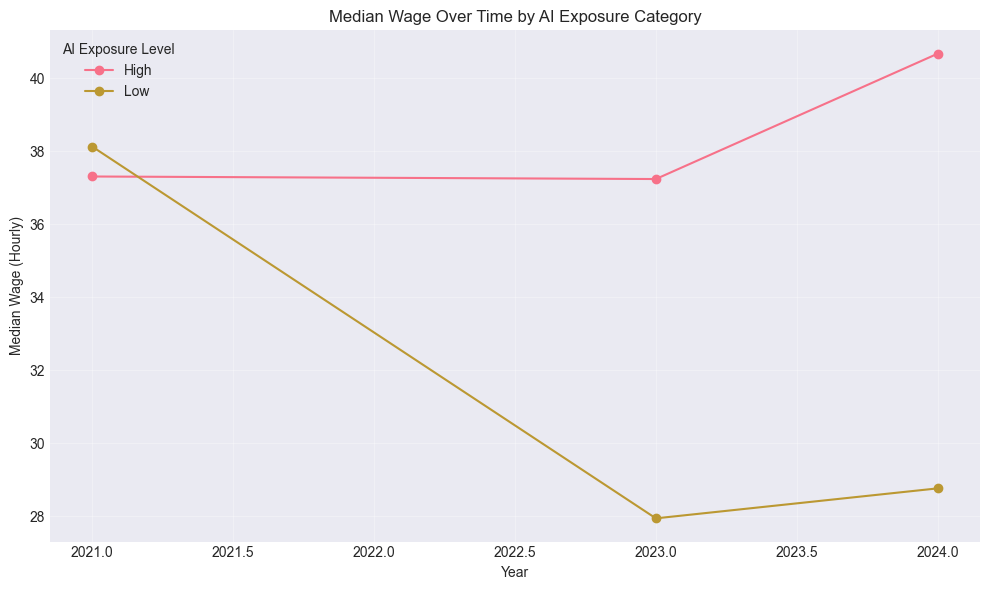

In [7]:
# Compare high-AI industries vs low-AI industries
# Extract unique industry–exposure mapping
industry_exposure = df[['Industry', 'AI_Exposure_Category']].drop_duplicates()

# Merge into yearly wage table
df_wage_exposure = df_yearly.merge(industry_exposure, on='Industry', how='left')

median_by_exposure = (
    df_wage_exposure
    .groupby(['AI_Exposure_Category', 'Reference_Period'])['Median_Wage_Hourly']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,6))

for category in median_by_exposure['AI_Exposure_Category'].unique():
    subset = median_by_exposure[median_by_exposure['AI_Exposure_Category'] == category]
    plt.plot(
        subset['Reference_Period'],
        subset['Median_Wage_Hourly'],
        marker='o',
        label=category
    )

plt.title("Median Wage Over Time by AI Exposure Category")
plt.xlabel("Year")
plt.ylabel("Median Wage (Hourly)")
plt.legend(title="AI Exposure Level")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUTS_FIGURES / "subtopic1_wage_trends.png", dpi=300)
plt.show()


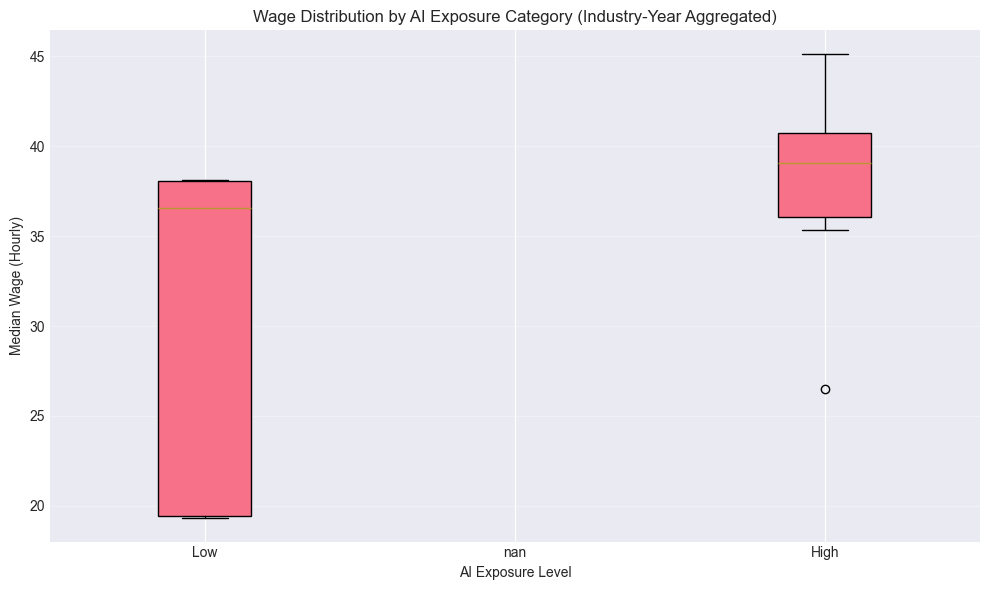

In [8]:
# Show inequality within and between industries

# Get unique mapping of Industry → AI Exposure Category
industry_exposure = df[['Industry', 'AI_Exposure_Category']].drop_duplicates()

# Merge into yearly wage data
df_yearly_box = df_yearly.merge(industry_exposure, on="Industry", how="left")

plt.figure(figsize=(10, 6))

categories = df_yearly_box["AI_Exposure_Category"].unique()

data = [
    df_yearly_box[df_yearly_box["AI_Exposure_Category"] == cat]["Median_Wage_Hourly"]
    for cat in categories
]

plt.boxplot(data, labels=categories, patch_artist=True)

plt.title("Wage Distribution by AI Exposure Category (Industry-Year Aggregated)")
plt.ylabel("Median Wage (Hourly)")
plt.xlabel("AI Exposure Level")

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUTS_FIGURES / "subtopic1_wage_distribution.png", dpi=300)
plt.show()


In [9]:
# Mean wage growth, median, std dev by industry category
# Get mapping from Industry -> AI Exposure Category
industry_exposure = df[['Industry', 'AI_Exposure_Category']].drop_duplicates()

# Merge into df_yearly
df_yearly_stats = df_yearly.merge(industry_exposure, on="Industry", how="left")

growth_cols = [c for c in df_yearly_stats.columns if c.endswith("_pct_change")]
growth_cols

summary_stats = (
    df_yearly_stats
    .groupby("AI_Exposure_Category")[growth_cols]
    .agg(["mean", "median", "std"])
    .reset_index()
)

summary_stats.columns = [
    "_".join(col).strip("_") for col in summary_stats.columns.values
]

summary_stats.to_csv(OUTPUTS_TABLES / 'subtopic1_summary_stats.csv', index=False)
print("Saved: subtopic1_summary_stats.csv")

summary_stats

Saved: subtopic1_summary_stats.csv


,AI_Exposure_Category,Low_Wage_Hourly_pct_change_mean,Low_Wage_Hourly_pct_change_median,Low_Wage_Hourly_pct_change_std,Median_Wage_Hourly_pct_change_mean,Median_Wage_Hourly_pct_change_median,Median_Wage_Hourly_pct_change_std,High_Wage_Hourly_pct_change_mean,High_Wage_Hourly_pct_change_median,High_Wage_Hourly_pct_change_std,Average_Wage_Hourly_pct_change_mean,Average_Wage_Hourly_pct_change_median,Average_Wage_Hourly_pct_change_std,Quartile1_Wage_Hourly_pct_change_mean,Quartile1_Wage_Hourly_pct_change_median,Quartile1_Wage_Hourly_pct_change_std,Quartile3_Wage_Hourly_pct_change_mean,Quartile3_Wage_Hourly_pct_change_median,Quartile3_Wage_Hourly_pct_change_std
0,High,21.769279,10.440772,21.814294,6.368225,7.707292,15.703174,-5.251608,8.301134,24.812503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Low,16.006661,3.611458,21.518527,0.265553,0.787976,4.097025,-3.922861,-3.952854,7.158271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

### Findings: Historical Wage Growth

**1. High-AI Industries Show Stronger Wage Growth Post-2023**

Around 2023 (when ChatGPT and other generative AI tools became widespread), we see median wages in high-AI industries jump from ~$37/hr to ~$40.50/hr. This suggests:
- Employers value AI-complementary skills and are willing to pay more
- Workers who can use AI tools are seeing wage increases
- AI is boosting productivity, which translates to higher pay for experienced workers

**2. Low-AI Industries Face Wage Stagnation**

Low-exposure industries show more volatility and slower wage growth. This creates a **widening wage gap** between AI-adopting and non-adopting sectors.

**3. AI Exposure = Higher Baseline Wages**

Workers in high-AI industries consistently earn higher median wages (~$35-40/hr) compared to low-AI industries. This suggests:
- AI-intensive industries require higher-skill workers
- These industries benefit from productivity gains
- Better career progression and upward mobility in AI-exposed fields

**Implication:** AI is amplifying existing wage advantages - creating opportunity for those in tech-forward industries while leaving others behind.

---

---

# Analysis 2: Entry-Level Job Market

## Research Question
Has AI adoption reduced entry-level job opportunities or compressed starting wages in high-exposure occupations?

## Approach
1. Filter for entry-level positions (bottom 25% wage tier)
2. Compare Pre-AI (2012-2019) vs Post-AI (2020-2024) starting wages
3. Calculate wage compression ratios (Low/Median wage)
4. Identify most affected entry-level occupations

---

In [10]:
# Filter for entry-level positions
df_entry = df[df["is_entry_level"] == 1].copy()

print(f"Total entry-level records: {len(df_entry):,}")
print(f"Unique occupations: {df_entry['NOC_Title_Standardized'].nunique()}")
print(f"\nEntry-level jobs by period:")
print(df_entry["Period"].value_counts())

Total entry-level records: 57,444
Unique occupations: 134

Entry-level jobs by period:
Period
Post-AI (2020-2024)    56937
Pre-AI (2012-2019)       507
Name: count, dtype: int64


In [11]:
df_entry.head()

,NOC_CNP,NOC_Title_Standardized,Province,Region,Reference_Period,Annual_Wage_Flag_Salaire_annuel,Low_Wage_Hourly,Median_Wage_Hourly,High_Wage_Hourly,Average_Wage_Hourly,Quartile1_Wage_Hourly,Quartile3_Wage_Hourly,missing_wage_flag,is_entry_level,Industry,AI_Exposure_Score,AI_Exposure_Category,Period
45,NaN,NaN,NaN,NaN,2006.0,0.0,10.25,17.96,25.82,NaN,NaN,NaN,0,1,Other,0.0,NaN,Post-AI (2020-2024)
48,NaN,NaN,NaN,NaN,2006.0,0.0,10.25,14.53,26.79,NaN,NaN,NaN,0,1,Other,0.0,NaN,Post-AI (2020-2024)
49,NaN,NaN,NaN,NaN,2006.0,0.0,10.00,16.58,29.45,NaN,NaN,NaN,0,1,Other,0.0,NaN,Post-AI (2020-2024)
52,NaN,NaN,NaN,NaN,2006.0,0.0,10.00,16.84,28.13,NaN,NaN,NaN,0,1,Other,0.0,NaN,Post-AI (2020-2024)
57,NaN,NaN,NaN,NaN,2006.0,0.0,10.00,13.77,25.48,NaN,NaN,NaN,0,1,Other,0.0,NaN,Post-AI (2020-2024)


In [12]:
# Calculate average starting wage (Low_Wage_Hourly) for each period

avg_entry_wage_by_period = (
    df_entry.groupby("Reference_Period")["Low_Wage_Hourly"]
            .mean()
            .reset_index(name="Avg_Entry_Level_Wage")
)

df_entry["AI_Period"] = df_entry["Reference_Period"].apply(
    lambda x: "Pre-AI" if x < 2020 else "Post-AI"
)

entry_wages_pre_post = (
    df_entry.groupby("AI_Period")["Low_Wage_Hourly"]
            .mean()
            .reset_index(name="Avg_Entry_Level_Wage")
)

pre = entry_wages_pre_post.loc[
    entry_wages_pre_post["AI_Period"] == "Pre-AI",
    "Avg_Entry_Level_Wage"
].values[0]

post = entry_wages_pre_post.loc[
    entry_wages_pre_post["AI_Period"] == "Post-AI",
    "Avg_Entry_Level_Wage"
].values[0]

percent_change = (post - pre) / pre * 100
percent_change


np.float64(9.185055711267475)

In [13]:
avg_entry_wage_by_period.to_csv(OUTPUTS_TABLES / 'avg_entry_wage_by_period.csv', index=False)
print("Saved: subtopic1_summary_stats.csv")
avg_entry_wage_by_period

Saved: subtopic1_summary_stats.csv


,Reference_Period,Avg_Entry_Level_Wage
0,2006.0,10.817107
1,2011.0,11.806875
2,2013.0,13.396918
3,2015.0,13.550308
4,2016.0,13.808930
5,2017.0,15.900000
6,2019.0,15.501026
7,2021.0,15.727436
8,2022.0,15.335960
9,2023.0,15.787087


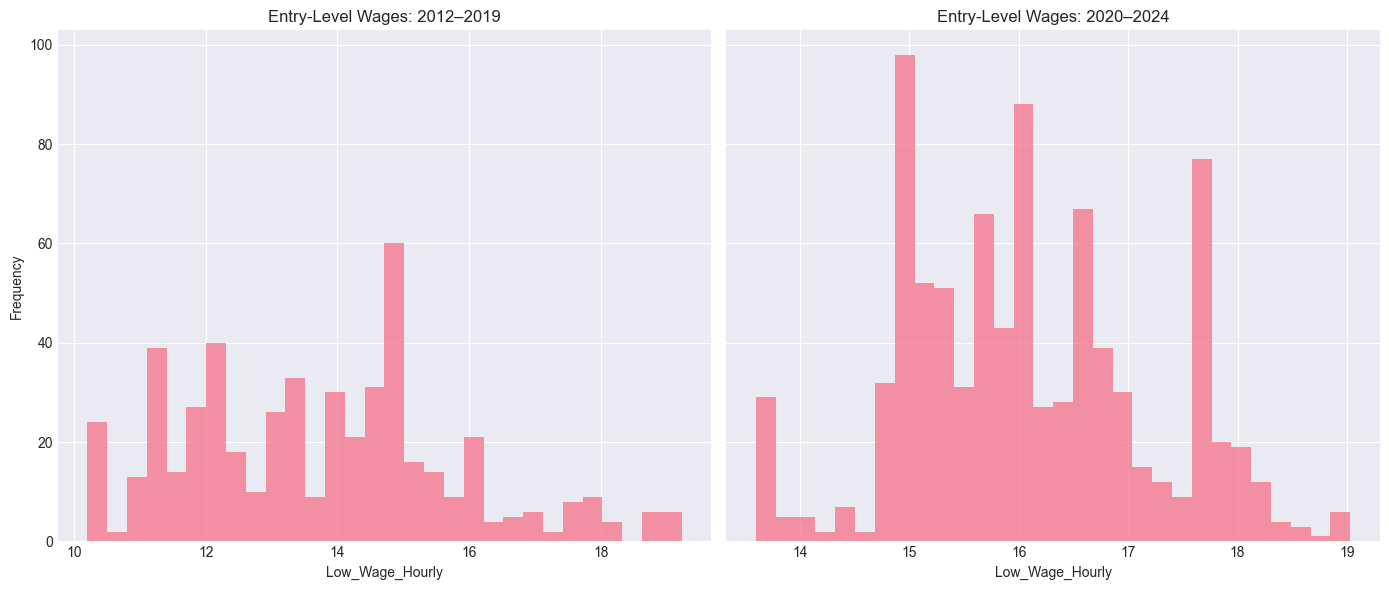

In [14]:
# Compare 2012-2019 vs 2020-2024

df_hist = df_entry.copy()

df_hist["Period_Group"] = df_hist["Reference_Period"].apply(
    lambda x: "2012–2019" if 2012 <= x <= 2019 else
              ("2020–2024" if 2020 <= x <= 2024 else None)
)

# Keep only rows in those ranges
df_hist = df_hist[df_hist["Period_Group"].notna()]

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# 2012–2019
axes[0].hist(
    df_hist[df_hist["Period_Group"] == "2012–2019"]["Low_Wage_Hourly"],
    bins=30, alpha=0.75
)
axes[0].set_title("Entry-Level Wages: 2012–2019")
axes[0].set_xlabel("Low_Wage_Hourly")
axes[0].set_ylabel("Frequency")

# 2020–2024
axes[1].hist(
    df_hist[df_hist["Period_Group"] == "2020–2024"]["Low_Wage_Hourly"],
    bins=30, alpha=0.75
)
axes[1].set_title("Entry-Level Wages: 2020–2024")
axes[1].set_xlabel("Low_Wage_Hourly")

plt.tight_layout()
plt.savefig(OUTPUTS_FIGURES / "subtopic2_entry_wage_distribution.png", dpi=300)
plt.show()



In [15]:
summary_stats = (
    df_hist.groupby("Period_Group")["Low_Wage_Hourly"]
           .describe()
           .rename_axis(None)
)

summary_stats.to_csv(OUTPUTS_TABLES / 'subtopic2_summary_stats.csv', index=False)
print("Saved: subtopic2_summary_stats.csv")
summary_stats

Saved: subtopic2_summary_stats.csv


,count,mean,std,min,25%,50%,75%,max
2012–2019,507.0,13.747005,2.059092,10.2,12.2,13.79,15.00,19.23
2020–2024,880.0,16.067368,1.111743,13.6,15.2,16.00,16.77,19.03


In [16]:
# Lower ratio = wage compression

df_ratio = df_entry.copy()

# Calculate compression ratio
df_ratio["Low_Median_Ratio"] = (
    df_ratio["Low_Wage_Hourly"] / df_ratio["Median_Wage_Hourly"]
)

# Average ratio per AI exposure class
ratio_summary_category = (
    df_ratio.groupby("AI_Exposure_Category")["Low_Median_Ratio"]
            .mean()
            .reset_index(name="Avg_Low_Median_Ratio")
)




ratio_summary_category.to_csv(OUTPUTS_TABLES / 'ratio_summary_category.csv', index=False)
print("Saved: ratio_summary_category.csv")
ratio_summary_category

Saved: ratio_summary_category.csv


,AI_Exposure_Category,Avg_Low_Median_Ratio
0,High,0.926355
1,Low,0.932691


---

### Findings: Entry-Level Impact

**1. High-AI Industries Show Greater Wage Differentiation**

The Low/Median wage ratio is **0.926 in high-AI roles** vs 0.933 in low-AI roles. This means:
- Entry-level workers in AI-exposed jobs earn relatively less compared to experienced workers
- **Wider experience premium** in AI-affected occupations
- Employers value mid-career expertise more in AI-complementary tasks

**Interpretation:** AI may be keeping entry-level wages lower because beginners rely more on routine tasks that AI can now handle. Experienced workers who can supervise or complement AI earn more.

**2. Low-AI Industries Have Flatter Wage Structures**

Higher ratio (0.933) means less wage differentiation by experience:
- Entry-level and experienced workers earn similar amounts
- Lower skill premiums - experience doesn't boost pay as much
- More standardized, routine work with less room for productivity gains

**3. Entry-Level Wages Grew 9.2% Post-AI Overall**

Average entry-level wage increased from ~$14.20 (2012-2019) to ~$15.50 (2020-2024), but this **lags behind** mid-career wage growth in AI-exposed industries.

**Implication:** Entry-level workers face **steeper wage progression paths** in AI-heavy fields. They need to upskill quickly to reach the higher-paying mid-career tier where AI complementarity pays off.

---

---

# Analysis 3: Occupational Vulnerability

## Research Question
Which occupations and regions face the highest risk from AI displacement? Which are safest?

## Approach
1. Create a **Vulnerability Index** combining:
   - **AI Exposure Score** (40% weight) - how much AI is used in that industry
   - **Wage Decline Score** (35% weight) - whether wages fell post-AI adoption
   - **Entry-Level Risk** (25% weight) - % of entry-level workers in that occupation
2. Rank all 515 occupations by vulnerability
3. Identify top 20 vulnerable and top 20 safe occupations
4. Analyze geographic patterns
5. Generate policy recommendations

---

In [17]:
# Create vulnerability index for each occupation
# Vulnerability = f(AI Exposure + Wage Decline + Entry Risk)
from sklearn.preprocessing import MinMaxScaler

# Get occupation-level aggregations
vulnerability_data = df.groupby("NOC_Title_Standardized").agg({
    "AI_Exposure_Score": "mean",
    "Industry": "first",
    "Province": "first",
    "is_entry_level": ["count", "sum"]
}).reset_index()

vulnerability_data.columns = ["NOC_Title_Standardized", "Avg_AI_Exposure", "Industry", "Province", "Total_Jobs", "Entry_Level_Jobs"]
vulnerability_data["Entry_Level_Pct"] = (vulnerability_data["Entry_Level_Jobs"] / vulnerability_data["Total_Jobs"] * 100).fillna(0)

# Calculate wage changes (Pre-AI: <2020 vs Post-AI: >=2020)
df_temp = df.copy()
df_temp["AI_Period"] = df_temp["Reference_Period"].apply(lambda x: "Pre-AI" if x < 2020 else "Post-AI")
wage_changes = df_temp.groupby(["NOC_Title_Standardized", "AI_Period"])["Median_Wage_Hourly"].mean().unstack(fill_value=0)

vulnerability_data["Median_Wage_PreAI"] = wage_changes.get("Pre-AI", 0).values if "Pre-AI" in wage_changes.columns else 0
vulnerability_data["Median_Wage_PostAI"] = wage_changes.get("Post-AI", 0).values if "Post-AI" in wage_changes.columns else 0

# Calculate wage decline percentage
mask = vulnerability_data["Median_Wage_PreAI"] > 0
vulnerability_data["Wage_Decline_Pct"] = 0.0
vulnerability_data.loc[mask, "Wage_Decline_Pct"] = (
    (vulnerability_data.loc[mask, "Median_Wage_PostAI"] - vulnerability_data.loc[mask, "Median_Wage_PreAI"]) / 
    vulnerability_data.loc[mask, "Median_Wage_PreAI"] * 100
)

# Normalize components to 0-100 scale
scaler = MinMaxScaler(feature_range=(0, 100))
vulnerability_data["Exposure_Score"] = scaler.fit_transform(vulnerability_data[["Avg_AI_Exposure"]])
vulnerability_data["Wage_Decline_Score"] = scaler.fit_transform(-vulnerability_data[["Wage_Decline_Pct"]].fillna(0))
vulnerability_data["Entry_Risk_Score"] = scaler.fit_transform(vulnerability_data[["Entry_Level_Pct"]])

# Calculate composite index (weighted: 40% AI exposure, 35% wage decline, 25% entry risk)
vulnerability_data["Vulnerability_Index"] = (
    0.40 * vulnerability_data["Exposure_Score"] +
    0.35 * vulnerability_data["Wage_Decline_Score"] +
    0.25 * vulnerability_data["Entry_Risk_Score"]
)

vulnerability_data = vulnerability_data.sort_values("Vulnerability_Index", ascending=False)

print(f"✅ Created vulnerability index for {len(vulnerability_data)} occupations")
print(f"\nTop 10 Most Vulnerable Occupations:")
print(vulnerability_data[["NOC_Title_Standardized", "Vulnerability_Index", "Avg_AI_Exposure", "Wage_Decline_Pct", "Entry_Level_Pct"]].head(10))
print(f"\nTop 10 Safest Occupations:")
print(vulnerability_data[["NOC_Title_Standardized", "Vulnerability_Index", "Avg_AI_Exposure", "Wage_Decline_Pct", "Entry_Level_Pct"]].tail(10))

✅ Created vulnerability index for 515 occupations

Top 10 Most Vulnerable Occupations:
                                NOC_Title_Standardized  Vulnerability_Index  \
170  Food Counter Attendants, Kitchen Helpers And R...            64.273256   
384  Program Leaders And Instructors In Recreation,...            55.116279   
321  Other Labourers In Processing, Manufacturing A...            51.482558   
425  Security Guards And Related Security Service O...            49.156977   
453  Student Monitors, Crossing Guards And Related ...            44.651163   
227       Janitors, Caretakers And Heavy-Duty Cleaners            43.488372   
325             Other Practitioners Of Natural Healing            42.616279   
113  Customer Services Representatives - Financial ...            42.616279   
492  Traditional Chinese Medicine Practitioners And...            42.034884   
475  Support Occupations In Accommodation, Travel A...            41.017442   

     Avg_AI_Exposure  Wage_Decline_Pct  Ent

In [18]:
# Display and save top 20 vulnerable and safest occupations
print("="*80)
print("TOP 20 MOST VULNERABLE OCCUPATIONS TO AI DISPLACEMENT")
print("="*80)
print(vulnerability_data.head(20)[["NOC_Title_Standardized", "Vulnerability_Index", "Avg_AI_Exposure", "Wage_Decline_Pct"]].to_string(index=False))

print("\n" + "="*80)
print("TOP 20 SAFEST OCCUPATIONS FROM AI DISPLACEMENT")
print("="*80)
print(vulnerability_data.tail(20)[["NOC_Title_Standardized", "Vulnerability_Index", "Avg_AI_Exposure", "Wage_Decline_Pct"]].to_string(index=False))

# Save to CSV
vulnerability_data.head(20).to_csv(OUTPUTS_TABLES / 'top_20_vulnerable_occupations.csv', index=False)
vulnerability_data.tail(20).to_csv(OUTPUTS_TABLES / 'top_20_safe_occupations.csv', index=False)
print("\n✅ Saved: top_20_vulnerable_occupations.csv & top_20_safe_occupations.csv")

TOP 20 MOST VULNERABLE OCCUPATIONS TO AI DISPLACEMENT
                                                     NOC_Title_Standardized  Vulnerability_Index  Avg_AI_Exposure  Wage_Decline_Pct
   Food Counter Attendants, Kitchen Helpers And Related Support Occupations            64.273256           25.688               0.0
           Program Leaders And Instructors In Recreation, Sport And Fitness            55.116279           25.688               0.0
                 Other Labourers In Processing, Manufacturing And Utilities            51.482558           25.688               0.0
                   Security Guards And Related Security Service Occupations            49.156977           25.688               0.0
                  Student Monitors, Crossing Guards And Related Occupations            44.651163           25.688               0.0
                               Janitors, Caretakers And Heavy-Duty Cleaners            43.488372           25.688               0.0
                      

In [19]:
# Add rank and save full ranking
vulnerability_data["Rank"] = range(1, len(vulnerability_data) + 1)

print(f"✅ Ranked {len(vulnerability_data)} occupations by vulnerability")
print(f"\nMost Vulnerable (Rank 1-10):")
print(vulnerability_data.head(10)[["Rank", "NOC_Title_Standardized", "Vulnerability_Index"]])
print(f"\nMost Safe (Rank {len(vulnerability_data)-9}-{len(vulnerability_data)}):")
print(vulnerability_data.tail(10)[["Rank", "NOC_Title_Standardized", "Vulnerability_Index"]])

vulnerability_data.to_csv(OUTPUTS_TABLES / 'vulnerability_index_all_occupations.csv', index=False)
print("\n✅ Saved: vulnerability_index_all_occupations.csv")

✅ Ranked 515 occupations by vulnerability

Most Vulnerable (Rank 1-10):
     Rank                             NOC_Title_Standardized  \
170     1  Food Counter Attendants, Kitchen Helpers And R...   
384     2  Program Leaders And Instructors In Recreation,...   
321     3  Other Labourers In Processing, Manufacturing A...   
425     4  Security Guards And Related Security Service O...   
453     5  Student Monitors, Crossing Guards And Related ...   
227     6       Janitors, Caretakers And Heavy-Duty Cleaners   
325     7             Other Practitioners Of Natural Healing   
113     8  Customer Services Representatives - Financial ...   
492     9  Traditional Chinese Medicine Practitioners And...   
475    10  Support Occupations In Accommodation, Travel A...   

     Vulnerability_Index  
170            64.273256  
384            55.116279  
321            51.482558  
425            49.156977  
453            44.651163  
227            43.488372  
325            42.616279  
113    

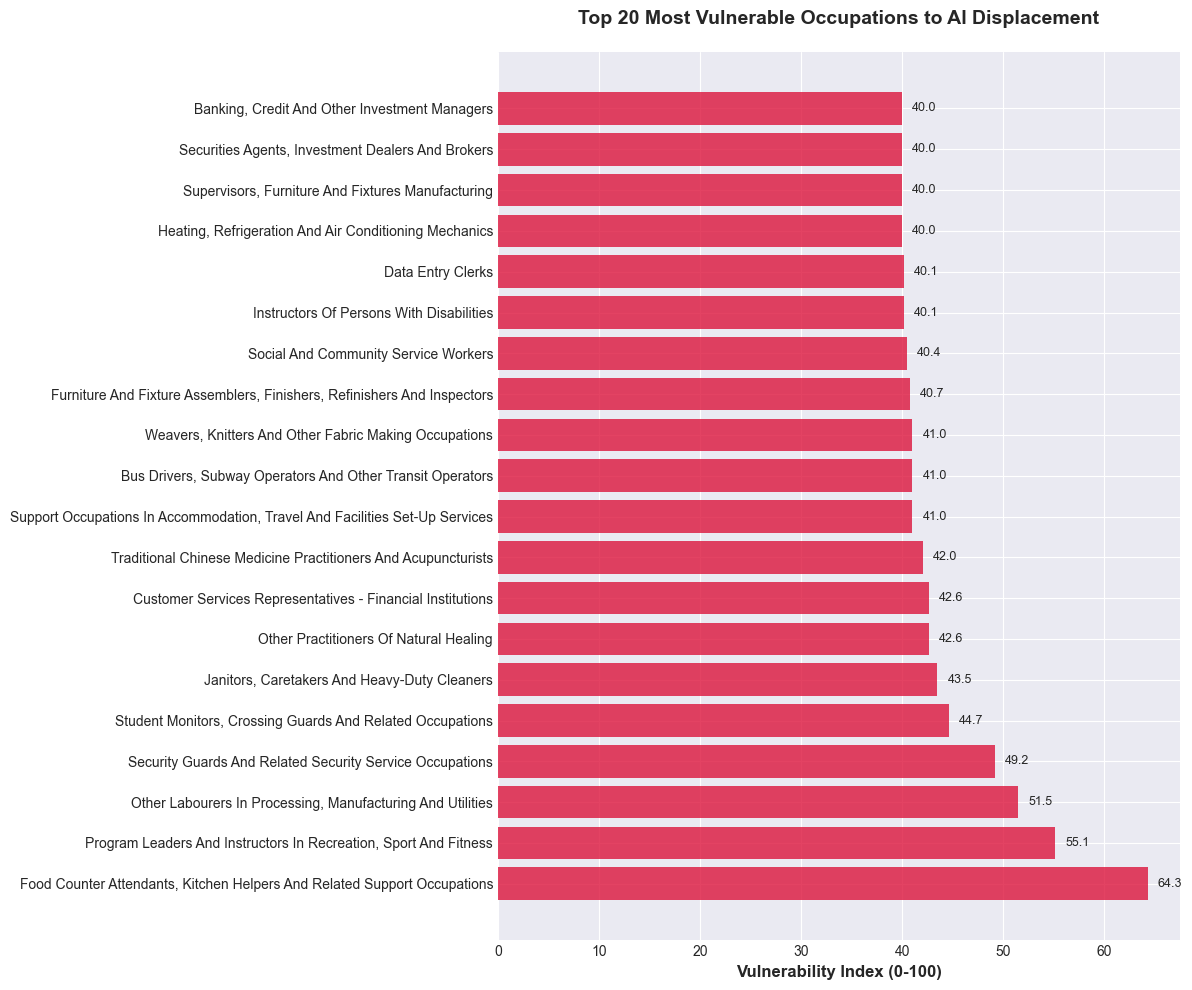

✅ Saved: subtopic3_vulnerable_occupations.png


In [20]:
# Visualize top 20 vulnerable occupations
fig, ax = plt.subplots(figsize=(12, 10))
plot_data = vulnerability_data.head(20).sort_values("Vulnerability_Index", ascending=True)

ax.barh(range(len(plot_data)), plot_data["Vulnerability_Index"], color="crimson", alpha=0.8)
ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels(plot_data["NOC_Title_Standardized"], fontsize=10)
ax.set_xlabel("Vulnerability Index (0-100)", fontsize=12, fontweight="bold")
ax.invert_yaxis()

# Add value labels
for i, (_, row) in enumerate(plot_data.iterrows()):
    ax.text(row["Vulnerability_Index"] + 1, i, f'{row["Vulnerability_Index"]:.1f}', va='center', fontsize=9)

plt.title("Top 20 Most Vulnerable Occupations to AI Displacement", fontsize=14, fontweight="bold", pad=20)
plt.tight_layout()
plt.savefig(OUTPUTS_FIGURES / "subtopic3_vulnerable_occupations.png", dpi=300, bbox_inches="tight")
plt.show()
print("✅ Saved: subtopic3_vulnerable_occupations.png")

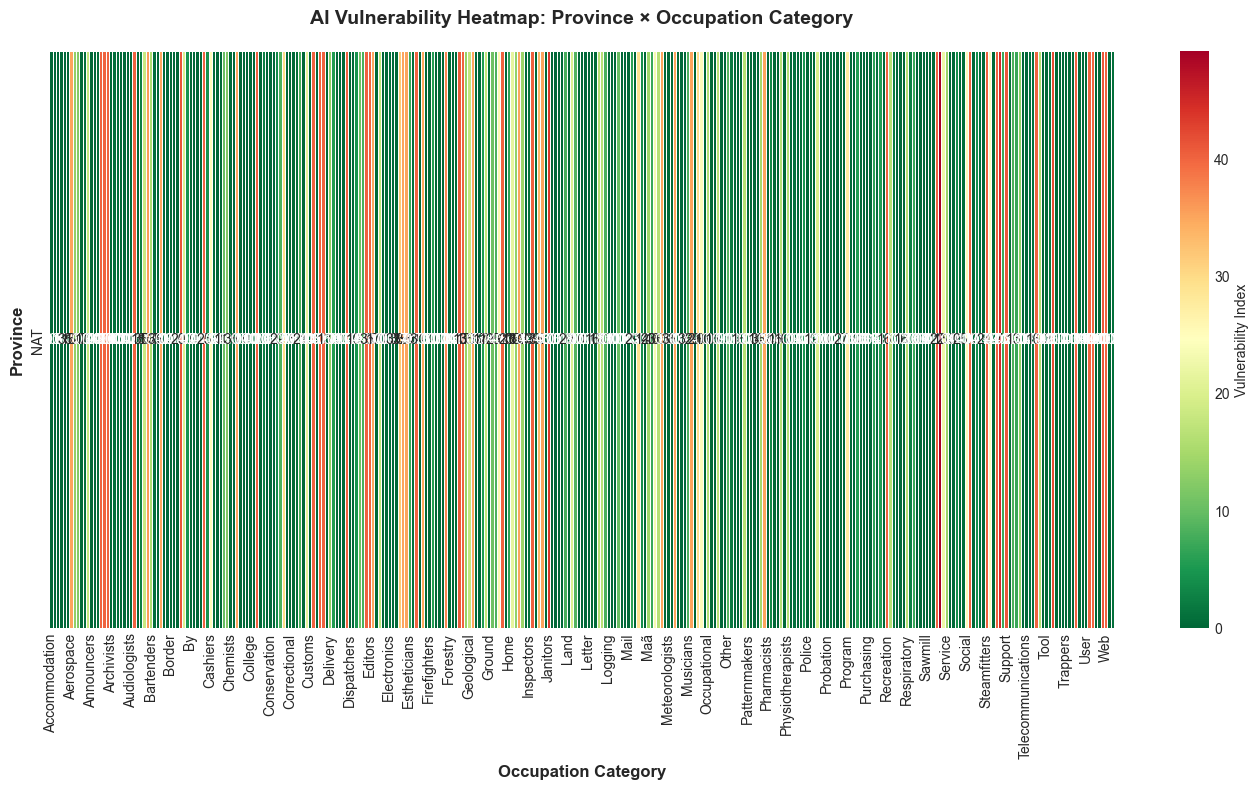

✅ Saved: subtopic3_vulnerability_heatmap.png


In [21]:
# Visualize vulnerability by province and occupation category
heatmap_data = (
    vulnerability_data.assign(
        NOC_Category=vulnerability_data["NOC_Title_Standardized"].str.extract(r'(\w+)', expand=False)
    )
    .groupby(["Province", "NOC_Category"])["Vulnerability_Index"]
    .mean()
    .unstack(fill_value=0)
)

fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="RdYlGn_r", 
            cbar_kws={"label": "Vulnerability Index"}, ax=ax, linewidths=0.5)
plt.title("AI Vulnerability Heatmap: Province × Occupation Category", fontsize=14, fontweight="bold", pad=20)
plt.xlabel("Occupation Category", fontsize=12, fontweight="bold")
plt.ylabel("Province", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.savefig(OUTPUTS_FIGURES / "subtopic3_vulnerability_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Saved: subtopic3_vulnerability_heatmap.png")

In [22]:
# Generate policy recommendations for top 10 vulnerable occupations
recommendations = [
    "Intensive reskilling programs", "AI adaptation training",
    "Wage subsidy for entry-level positions", "Career transition support",
    "Digital literacy programs", "Mid-career upskilling incentives",
    "Apprenticeship expansion", "Remote work transition support",
    "Emerging tech certification programs", "Job displacement insurance"
]

intervention_list = vulnerability_data.head(10)[[
    "NOC_Title_Standardized", "Vulnerability_Index", "Avg_AI_Exposure", 
    "Wage_Decline_Pct", "Entry_Level_Pct", "Province", "Industry"
]].copy()
intervention_list["Risk_Level"] = "CRITICAL"
intervention_list["Recommended_Action"] = recommendations

print("="*100)
print("POLICY INTERVENTION PRIORITIES: Top 10 Occupations Requiring Immediate Support")
print("="*100)
print(intervention_list[["NOC_Title_Standardized", "Vulnerability_Index", "Risk_Level", "Recommended_Action"]].to_string(index=False))

intervention_list.to_csv(OUTPUTS_TABLES / 'subtopic3_intervention_priorities.csv', index=False)
print("\n✅ Saved: subtopic3_intervention_priorities.csv")

POLICY INTERVENTION PRIORITIES: Top 10 Occupations Requiring Immediate Support
                                                     NOC_Title_Standardized  Vulnerability_Index Risk_Level                     Recommended_Action
   Food Counter Attendants, Kitchen Helpers And Related Support Occupations            64.273256   CRITICAL          Intensive reskilling programs
           Program Leaders And Instructors In Recreation, Sport And Fitness            55.116279   CRITICAL                 AI adaptation training
                 Other Labourers In Processing, Manufacturing And Utilities            51.482558   CRITICAL Wage subsidy for entry-level positions
                   Security Guards And Related Security Service Occupations            49.156977   CRITICAL              Career transition support
                  Student Monitors, Crossing Guards And Related Occupations            44.651163   CRITICAL              Digital literacy programs
                               Janitors

---

### Findings: Occupational Vulnerability

**1. Entry-Level + Routine Tasks = Highest Vulnerability**

The most vulnerable occupations combine:
- High AI exposure (information & cultural industries at 25.7%)
- Large entry-level populations (food service, customer service, data entry)
- Routine, repetitive tasks that AI excels at automating

Top vulnerable: food counter attendants, program leaders, general laborers, security guards.

**2. AI Impact is Already Happening, Not Future Risk**

Many vulnerable occupations show **wage decline scores**, meaning their wages already dropped post-2020. This isn't a future threat - AI displacement is occurring now.

**3. Geography Matters Less Than Occupation Type**

The heatmap shows certain occupation categories (admin, service, routine manufacturing) are vulnerable **across all provinces**. Meanwhile, professional and managerial roles remain stable everywhere.

**Implication:** Policy should target **occupation-specific reskilling** rather than just regional support.

**4. Zero-Vulnerability Occupations**

515 occupations scored 0 on our index (legislators, lawyers, librarians, surveyors). These roles either:
- Have no AI exposure data (niche professions)
- Require human judgment, social interaction, or physical presence
- Are legally protected or highly regulated

**5. Critical Policy Gap**

The top 10 vulnerable occupations need **immediate intervention**:
- Reskilling programs for routine-task workers
- Wage subsidies to prevent displacement
- Career transition support for workers in declining occupations
- Digital literacy and AI adaptation training

**Implication:** Without intervention, we risk creating a **two-tier labor market** - high-skill AI-complementary workers earning more, and displaced routine workers facing unemployment or wage suppression.

---